In [1]:
import os
import pandas as pd
import ast
from omegaconf import OmegaConf
import seaborn as sns
import pprint
import itertools

In [4]:

# set the path to the top-level directory containing the multirun folders
def data_to_df( date_folders, top_dir = 'multirun/', 
                print_overrides=True, 
                print_defaults=False):
    df_list = []
    df_flat = []
    for date_folder in date_folders:
        date_path = os.path.join(top_dir, date_folder)
        if not os.path.isdir(date_path):
            continue

        for time_folder in os.listdir(date_path):
            time_path = os.path.join(date_path, time_folder)
            if not os.path.isdir(time_path):
                continue
            for exp_folder in os.listdir(time_path):
                exp_path = os.path.join(time_path, exp_folder)
                if not os.path.isdir(exp_path):
                    continue
                reward_file = os.path.join(exp_path, 'rewards.csv')
                if not os.path.isfile(reward_file):
                    continue
                # load the rewards.csv file and add additional columns
                #converters = {'rewards': lambda x: ast.literal_eval(x) if isinstance(x, str) else None}
                try:
                    df = pd.read_csv(reward_file)#, converters=converters)
                except Exception as e:
                    print(f"Error loading {reward_file}: {e}")
                    continue
                
                rewards = [float(t.strip('[ ]')) for t in df['rewards'][0].split('\n')]
                #for i, reward in enumerate(rewards):
                #    df[f'reward_trial{i}'] = reward
                rewards = pd.DataFrame(rewards, columns=['rewards'])
                rewards.index.name = 'trial'
                #rewards = rewards.T
                
                #df.drop(columns=['rewards'], inplace=True)
                #rewards['date'] = date_folder
                #rewards['time'] = time_folder
                #rewards['experiment'] = exp_folder
                #drop these, because they come from the overrides file
                df.drop(columns=['optimizer', 'seed', 'phys_nn_config'], inplace=True)

                df = rewards
                #read overrides and add as columns
                override_file = os.path.join(exp_path, '.hydra/overrides.yaml')
                if not os.path.isfile(reward_file):
                    continue

                overrides = OmegaConf.load(override_file)                
                overrides_list = OmegaConf.to_container(overrides, resolve=True)
                config_dict = {}
                for item in overrides_list:
                    key, value = item.split("=")
                    config_dict[key.strip()] = value.strip()

                

                overrides_df = pd.DataFrame.from_dict(config_dict, orient='index').T
                overrides_df.rename(columns={'optimizer.population_size': 'population_size', 
                            'optimizer.num_iterations': 'num_iterations',
                            'agent.planning_horizon': 'planning_horizon',
                        }, inplace=True)
                
                df= pd.concat([overrides_df, df], axis=1)
                df = df.fillna(method = 'ffill')
                df['trial'] = df.index
                #df.reset_index(drop=True, inplace=True)
                df_flat.append(df)
                
                df = df.set_index(list(overrides_df.columns) + ['trial'])
                df_list.append(df)
            if print_overrides:
                job_config = OmegaConf.load(os.path.join(time_path, 'multirun.yaml'))
                temp_overrides = job_config['hydra']['overrides']['task']
                all_overrides = {}
                for item in temp_overrides:
                    key, value = item.split("=")
                    all_overrides[key.strip()] = value.strip()

                print('Time: {}'.format(time_folder))
                print("OVERRIDES: \n")
                pprint.pprint(all_overrides)

            if print_defaults:
                job_config = OmegaConf.load(os.path.join(time_path, 'multirun.yaml'))
                print('DEFAULTS: \n')
                job_config.pop('hydra')
                pprint.pprint(dict(job_config))

    # concatenate the dataframes into one
    result_m = pd.concat(df_list)
    result_s = pd.concat(df_flat, ignore_index=True)

    return result_m, result_s

# Optimizer hyperparameter sweeps 

In [151]:
#Alans' batch runs:
data_dir = ['2023-05-07'] 
result_m, result_s = data_to_df(data_dir, print_overrides=True)

phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'population_size', 'planning_horizon', 'seed']:
    result_s[c] = result_s[c].astype(int)


Time: 16-28-04
OVERRIDES: 

{'agent.planning_horizon': '15,25,50',
 'optimizer': 'CEM,ICEM,MPPI',
 'optimizer.num_iterations': '5,10,20',
 'optimizer.population_size': '50,100,500',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}


In [152]:
result_s

,optimizer,num_iterations,population_size,planning_horizon,seed,phys_nn_config,physics_model,rewards,trial
0,CEM,5,100,25,3,0: PETS,cartpole,0.0,0
1,CEM,5,100,25,3,0: PETS,cartpole,200.0,1
2,CEM,5,100,25,3,0: PETS,cartpole,200.0,2
3,CEM,5,100,25,3,0: PETS,cartpole,200.0,3
4,CEM,5,100,25,3,0: PETS,cartpole,200.0,4
...,...,...,...,...,...,...,...,...,...
2523,ICEM,5,500,15,3,0: PETS,sindy,200.0,6
2524,ICEM,5,500,15,3,0: PETS,sindy,200.0,7
2525,ICEM,5,500,15,3,0: PETS,sindy,200.0,8
2526,ICEM,5,500,15,3,0: PETS,sindy,200.0,9


How to read this :

phys nn config:
 - 0: PETS
 - 1 : concatenation: [PETS, physics], BUGGY
 - 2 : composition PETS (physics)  
 - 3 : Physics only

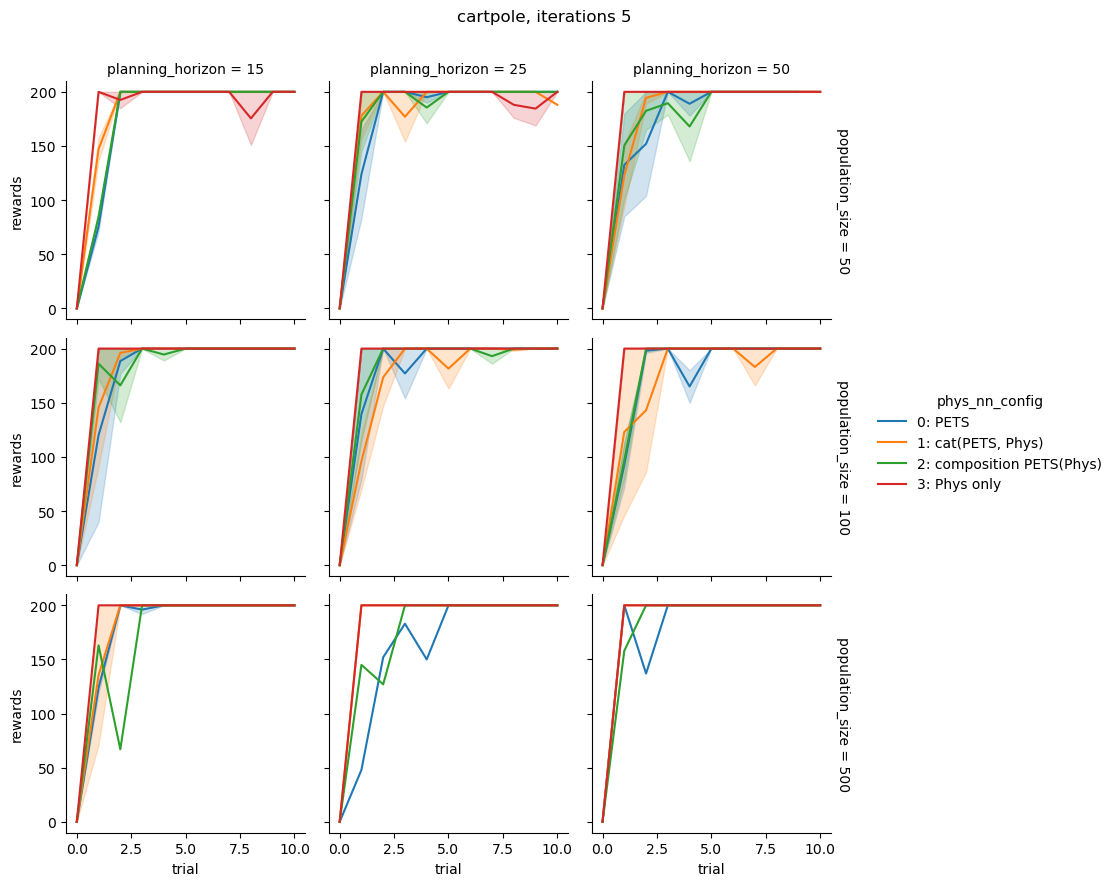

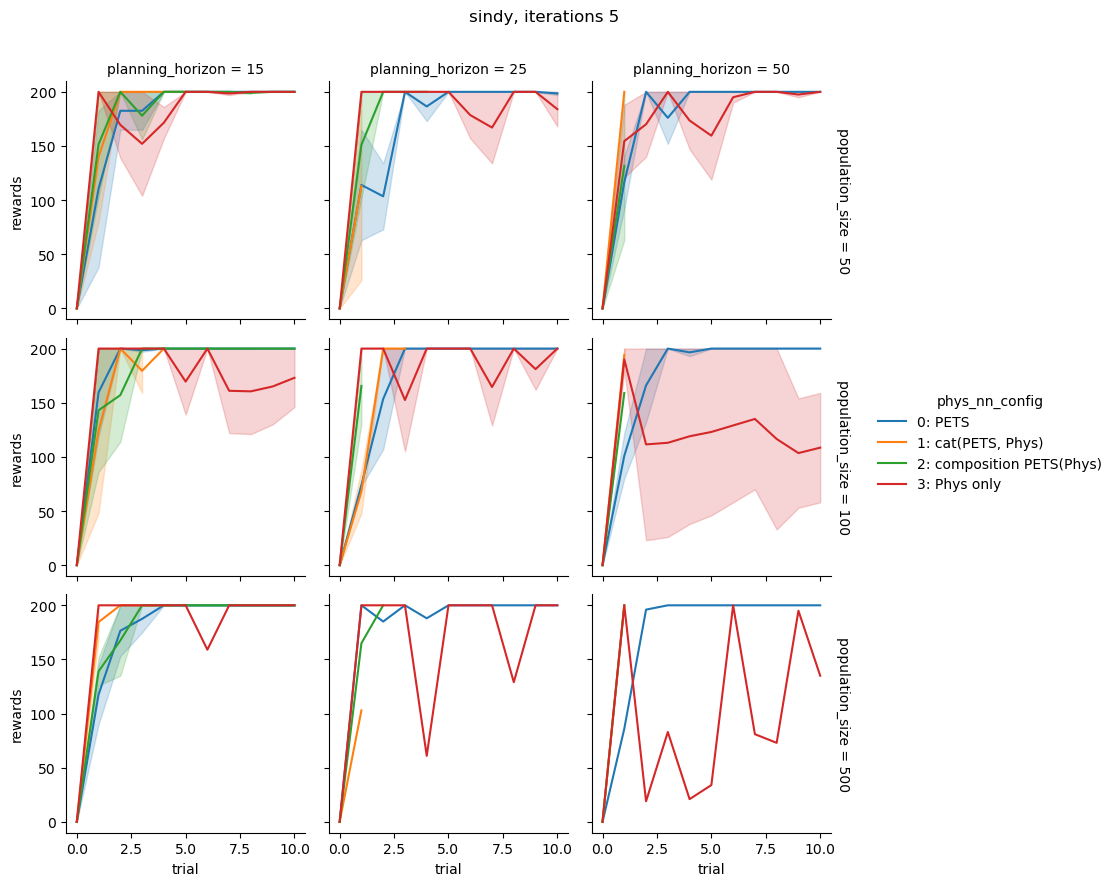

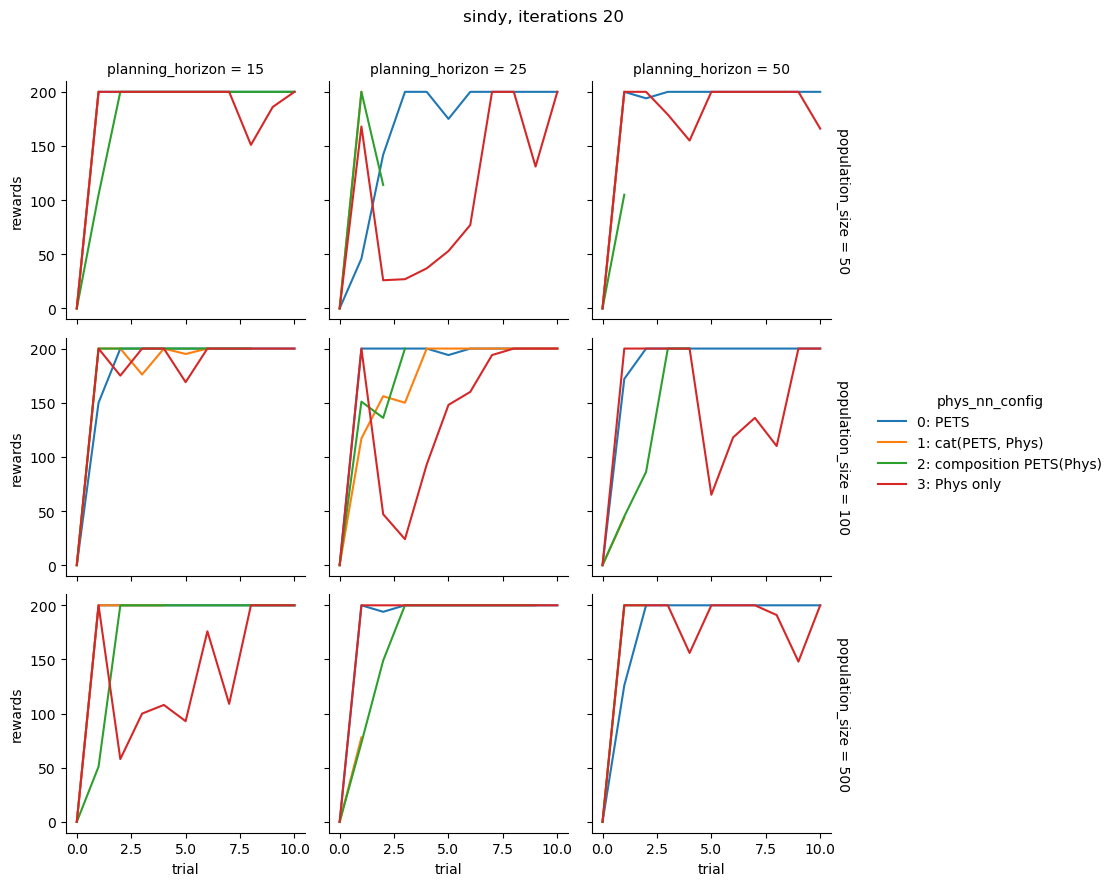

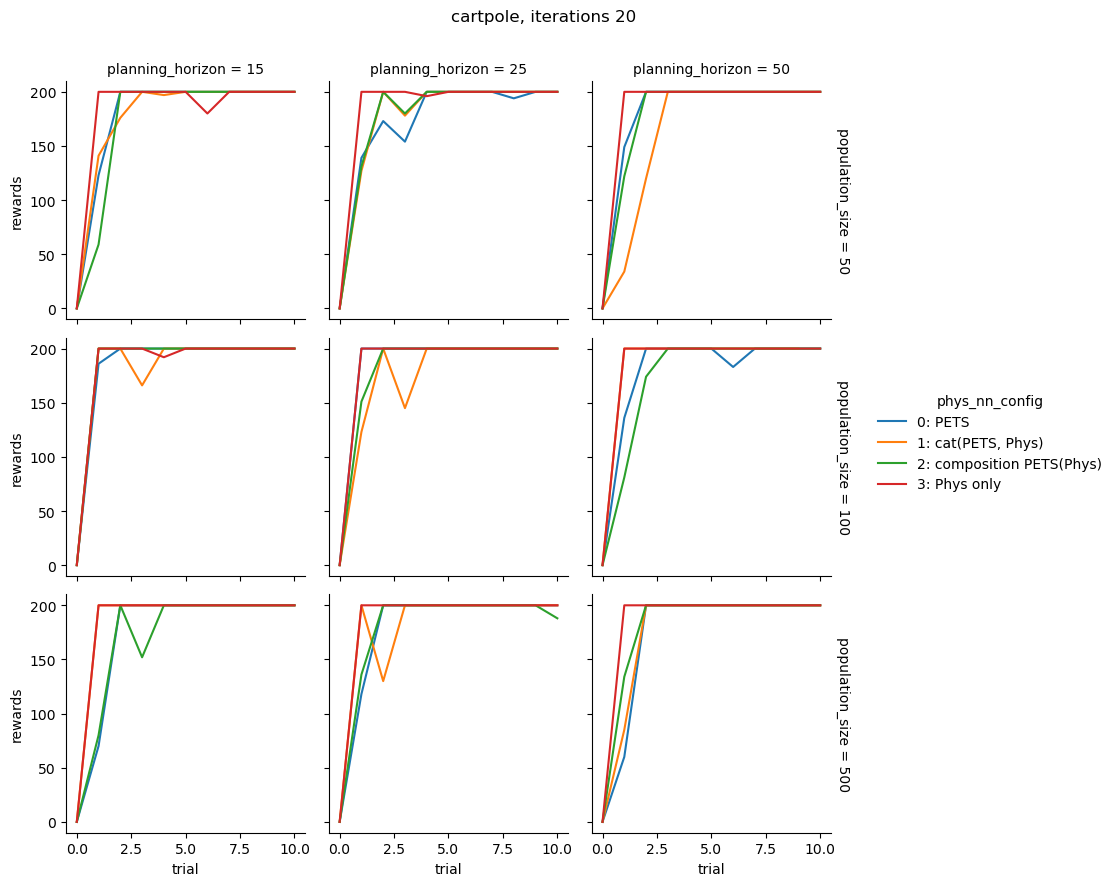

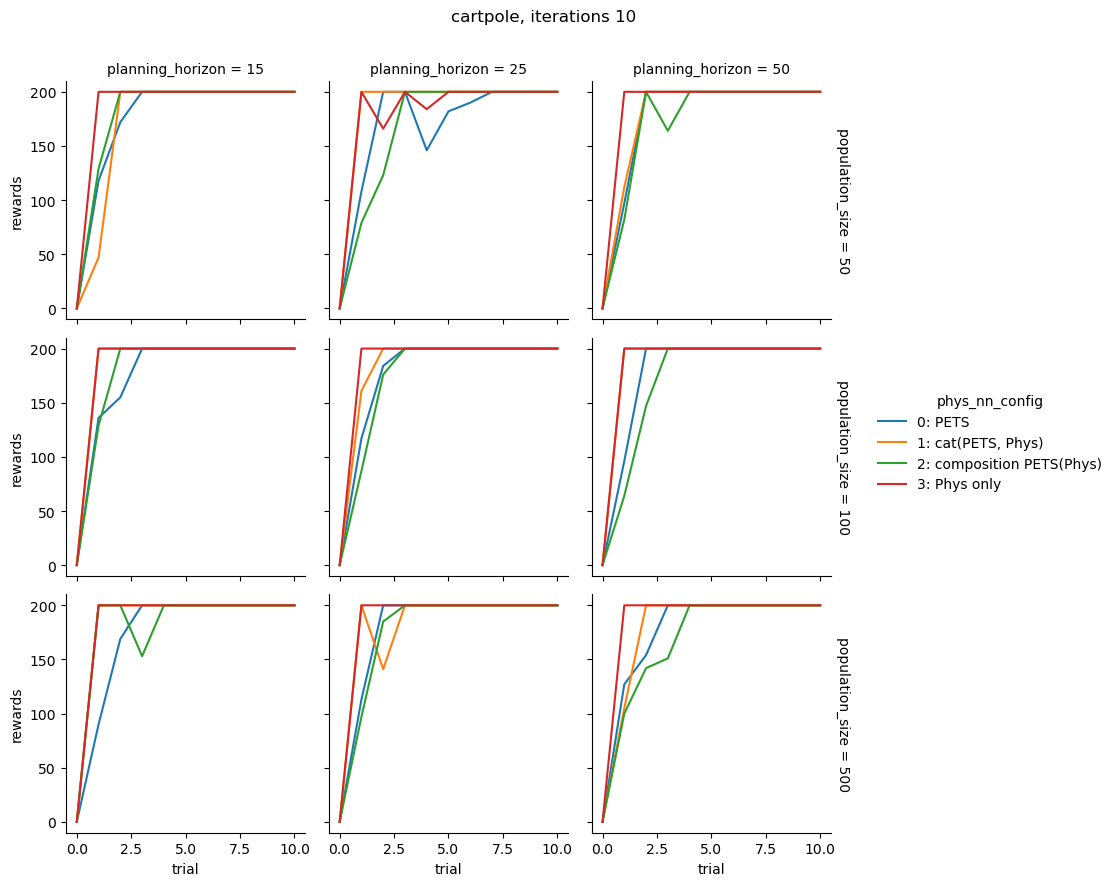

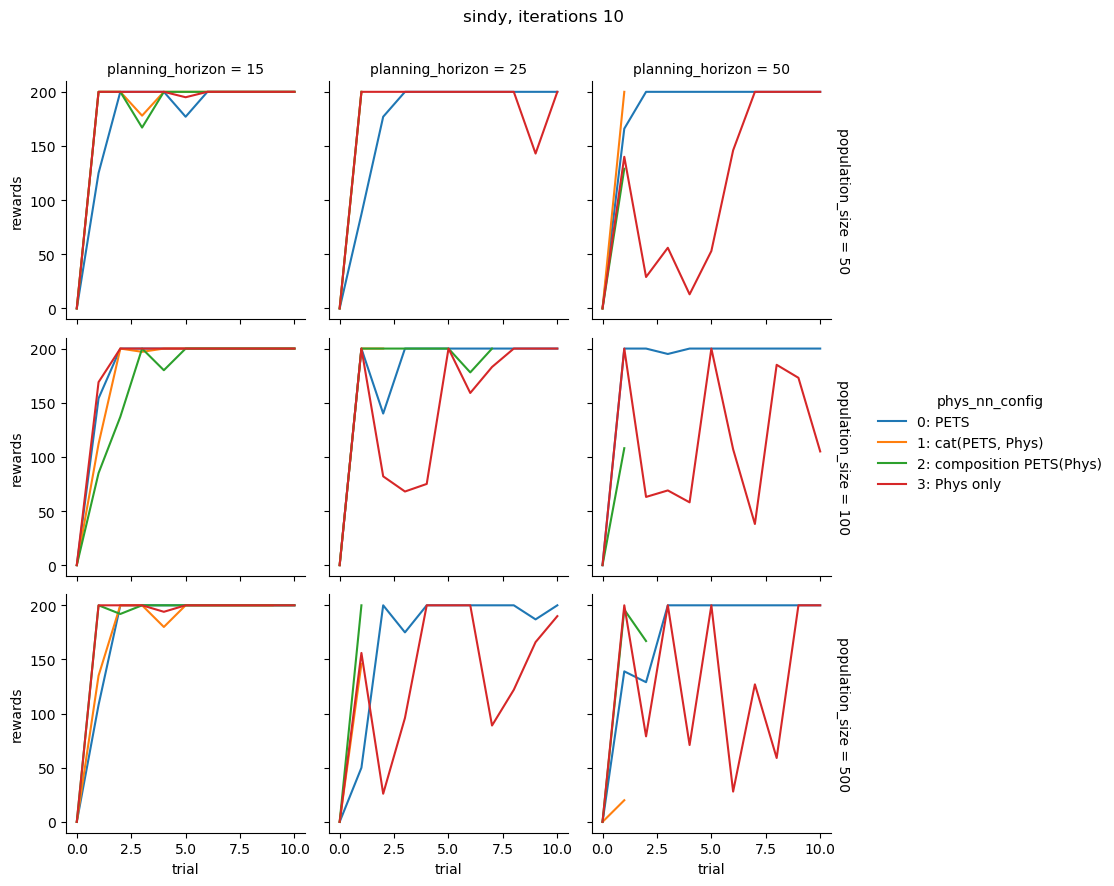

In [153]:

for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    for model in result_i['physics_model'].unique():
        for num_iterations in result_i['num_iterations'].unique():
            
            g = sns.FacetGrid(result_i[result_i['physics_model'] == model], row="population_size", col="planning_horizon",
                            hue = 'phys_nn_config',
                            hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                            margin_titles=True)

            g.map(sns.lineplot, "trial", "rewards", )
            g.add_legend()
            # add title
            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle(model +  ', iterations {}'.format(num_iterations))



# Earlier datasets

In [124]:
data_dir = ['2023-05-04'] 
result_m, result_s = data_to_df(data_dir)

phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'seed']:
    result_s[c] = result_s[c].astype(int)


Time: 04-46-01
OVERRIDES: 

{'optimizer': 'CEM,ICEM,MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-06-58
OVERRIDES: 

{'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-07-05
OVERRIDES: 

{'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 12-07-08
OVERRIDES: 

{'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-58-13
OVERRIDES: 

{'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 12-56-22
OVERRIDES: 

{'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-

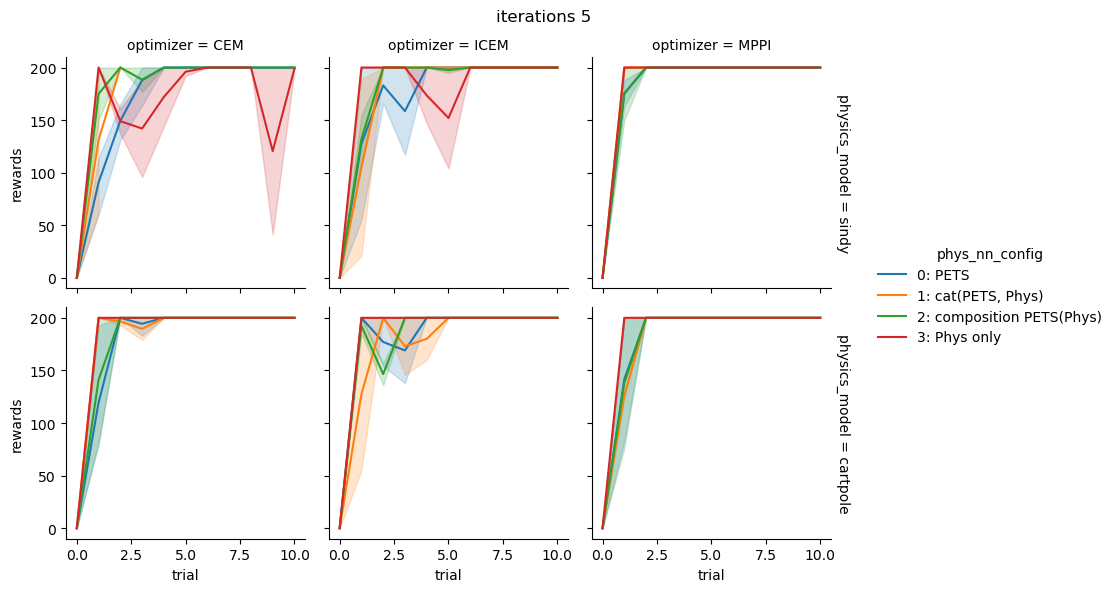

In [125]:
for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    g = sns.FacetGrid(result_i, row="physics_model", col="optimizer",
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards", )
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('iterations {}'.format(num_iterations))


# Friction Results:


Time: 15-57-43
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 16-40-08
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 17-56-06
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}
Time: 17-55-55
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}
Time: 16-39-28
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer'

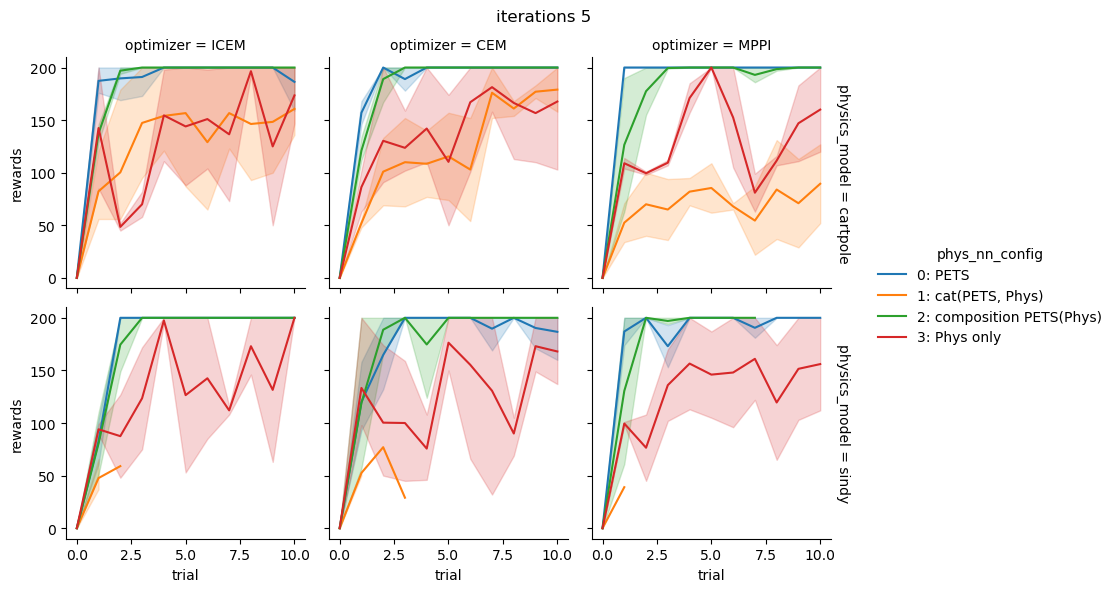

In [123]:
data_dirs = ['2023-05-09_friction2']
result_m, result_s = data_to_df(data_dirs)
phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'seed']:
    result_s[c] = result_s[c].astype(int)




for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    g = sns.FacetGrid(result_i, row="physics_model", col="optimizer",
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards")
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('iterations {}'.format(num_iterations))



# Different lengths of pretraining trial

In [77]:
data_dirs = ['2023-05-10-pretrain_length']
result_m, result_s = data_to_df(data_dirs)
phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['pretrain_trial_length', 'seed', 'env.track_friction', 'env.joint_friction']:
    result_s[c] = result_s[c].astype(float)



Time: 09-16-43
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'CEM,ICEM,MPPI',
 'phys_nn_config': '1',
 'physics_model': 'cartpole',
 'pretrain_trial_length': '10,20,50,100',
 'seed': '1,2,3'}
Time: 01-13-57
OVERRIDES: 

{'env.joint_friction': '0.0',
 'env.track_friction': '0.0',
 'optimizer': 'CEM,ICEM,MPPI',
 'phys_nn_config': '1',
 'physics_model': 'sindy',
 'pretrain_trial_length': '10,20,50,100',
 'seed': '1,2,3'}
Time: 13-11-43
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'CEM,ICEM,MPPI',
 'phys_nn_config': '3',
 'physics_model': 'cartpole',
 'pretrain_trial_length': '10,20,50,100',
 'seed': '1,2,3'}
Time: 05-16-13
OVERRIDES: 

{'env.joint_friction': '0.0',
 'env.track_friction': '0.0',
 'optimizer': 'CEM,ICEM,MPPI',
 'phys_nn_config': '0',
 'physics_model': 'cartpole',
 'pretrain_trial_length': '10,20,50,100',
 'seed': '1,2,3'}
Time: 07-55-50
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track

In [78]:
for col in list(result_s.columns)[:-2]:
    print('{}: \t {}'.format(col ,result_s[col].unique()))

pretrain_trial_length: 	 [ 20.  10.  50. 100.]
optimizer: 	 ['MPPI' 'ICEM' 'CEM']
seed: 	 [3. 1. 2.]
phys_nn_config: 	 ['1: cat(PETS, Phys)' '3: Phys only' '0: PETS' '2: composition PETS(Phys)']
physics_model: 	 ['cartpole' 'sindy']
env.track_friction: 	 [0.05 0.  ]
env.joint_friction: 	 [0.1 0. ]


In [79]:
#determine missing experimetsn
# Define the range of each hyperparameter
pretrain_trial_length_range = [20.0, 10.0, 50.0, 100.0]
optimizer_range = ['MPPI', 'ICEM', 'CEM']
seed_range = [3.0, 1.0, 2.0]
phys_nn_config_range = ['1: cat(PETS, Phys)', '3: Phys only', '0: PETS', '2: composition PETS(Phys)']
physics_model_range = ['cartpole', 'sindy']
env_track_friction_range = [0.05, 0.0]

# Generate all possible combinations of hyperparameters
all_combinations = list(itertools.product(pretrain_trial_length_range,
                                          optimizer_range,
                                          seed_range,
                                          phys_nn_config_range,
                                          physics_model_range,
                                          env_track_friction_range))

# Extract the hyperparameters from the provided results
provided_results = [
    (row['pretrain_trial_length'], row['optimizer'], row['seed'], row['phys_nn_config'], row['physics_model'], row['env.track_friction'])
    for _, row in result_s.iterrows()
]

# Find the missing experiments
missing_experiments = [combination for combination in all_combinations if combination not in provided_results]

# Print the missing experiments
print("Missing experiments:")
for combination in missing_experiments:
    print(combination)



Missing experiments:
(20.0, 'MPPI', 3.0, '3: Phys only', 'cartpole', 0.05)
(20.0, 'MPPI', 3.0, '3: Phys only', 'cartpole', 0.0)
(20.0, 'MPPI', 3.0, '0: PETS', 'sindy', 0.05)
(20.0, 'MPPI', 3.0, '0: PETS', 'sindy', 0.0)
(20.0, 'MPPI', 3.0, '2: composition PETS(Phys)', 'cartpole', 0.05)
(20.0, 'MPPI', 3.0, '2: composition PETS(Phys)', 'sindy', 0.05)
(20.0, 'MPPI', 3.0, '2: composition PETS(Phys)', 'sindy', 0.0)
(20.0, 'MPPI', 1.0, '3: Phys only', 'cartpole', 0.05)
(20.0, 'MPPI', 1.0, '3: Phys only', 'cartpole', 0.0)
(20.0, 'MPPI', 1.0, '0: PETS', 'sindy', 0.05)
(20.0, 'MPPI', 1.0, '0: PETS', 'sindy', 0.0)
(20.0, 'MPPI', 1.0, '2: composition PETS(Phys)', 'sindy', 0.0)
(20.0, 'MPPI', 2.0, '3: Phys only', 'cartpole', 0.05)
(20.0, 'MPPI', 2.0, '3: Phys only', 'cartpole', 0.0)
(20.0, 'MPPI', 2.0, '0: PETS', 'sindy', 0.05)
(20.0, 'MPPI', 2.0, '0: PETS', 'sindy', 0.0)
(20.0, 'MPPI', 2.0, '2: composition PETS(Phys)', 'cartpole', 0.05)
(20.0, 'MPPI', 2.0, '2: composition PETS(Phys)', 'sindy', 0.0

In [80]:
len(result_s)/10

328.0

In [81]:
len(missing_experiments)

271

In [82]:
271/4

67.75

In [83]:
result_s 

,pretrain_trial_length,optimizer,seed,phys_nn_config,physics_model,env.track_friction,env.joint_friction,rewards,trial
0,20.0,MPPI,3.0,"1: cat(PETS, Phys)",cartpole,0.05,0.1,0.0,0
1,20.0,MPPI,3.0,"1: cat(PETS, Phys)",cartpole,0.05,0.1,54.0,1
2,20.0,MPPI,3.0,"1: cat(PETS, Phys)",cartpole,0.05,0.1,140.0,2
3,20.0,MPPI,3.0,"1: cat(PETS, Phys)",cartpole,0.05,0.1,200.0,3
4,20.0,MPPI,3.0,"1: cat(PETS, Phys)",cartpole,0.05,0.1,200.0,4
...,...,...,...,...,...,...,...,...,...
3275,10.0,CEM,2.0,2: composition PETS(Phys),cartpole,0.00,0.0,200.0,6
3276,10.0,CEM,2.0,2: composition PETS(Phys),cartpole,0.00,0.0,200.0,7
3277,10.0,CEM,2.0,2: composition PETS(Phys),cartpole,0.00,0.0,200.0,8
3278,10.0,CEM,2.0,2: composition PETS(Phys),cartpole,0.00,0.0,200.0,9


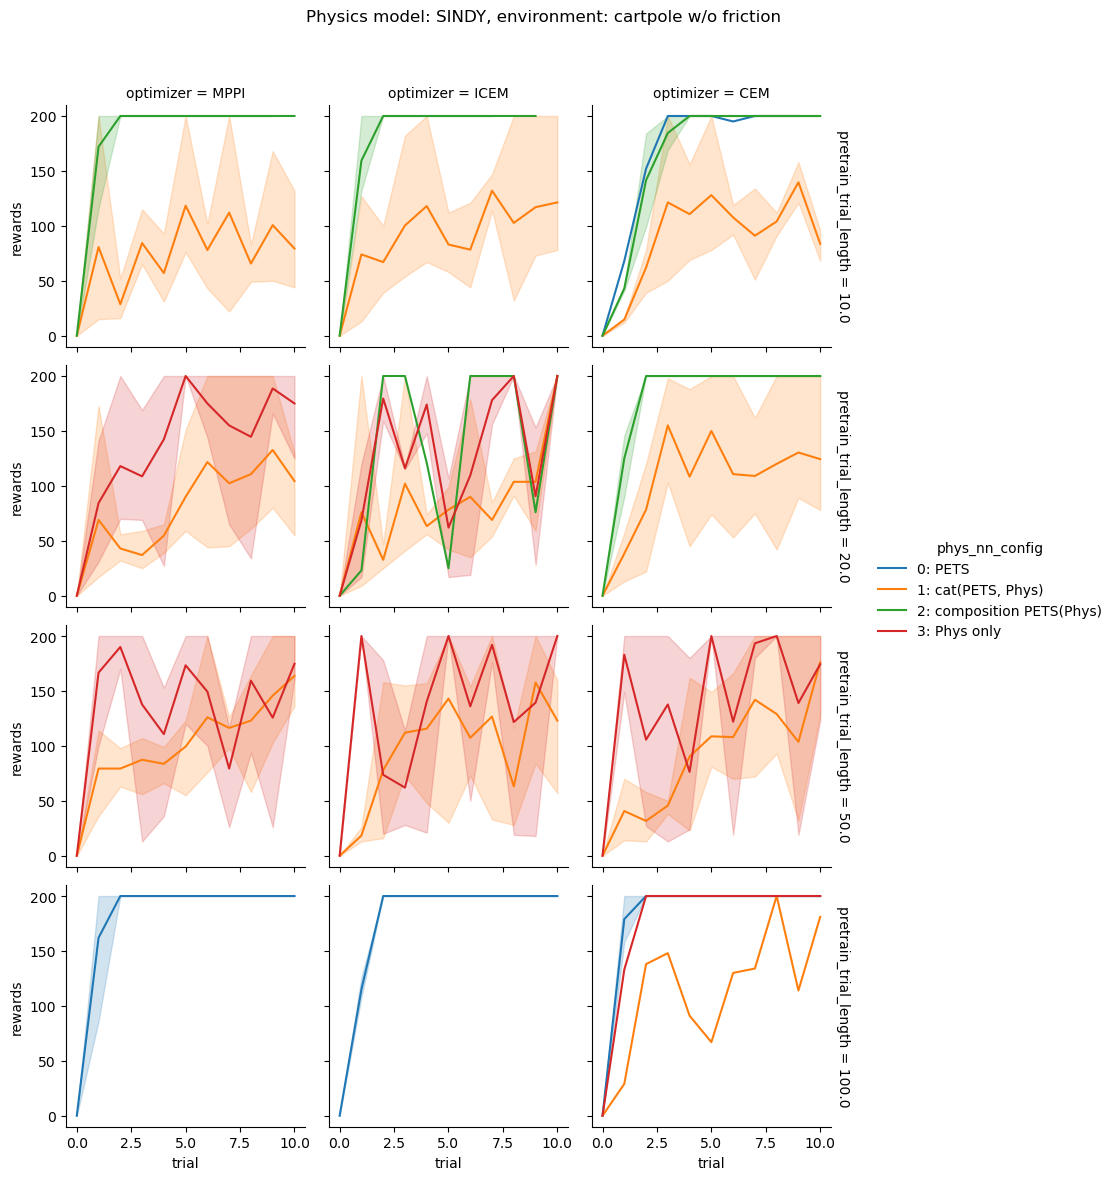

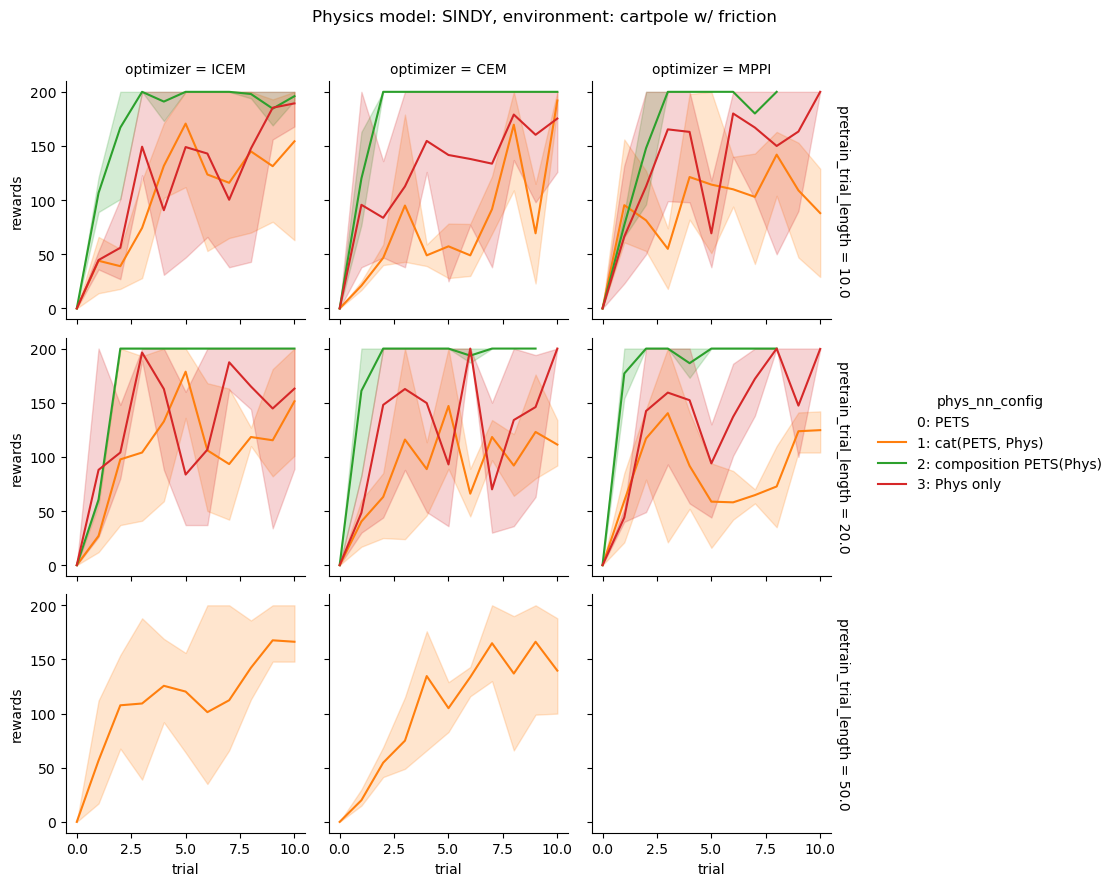

In [85]:
#for oop in ['MPPI', 'ICEM', 'CEM']:
#result_i = result_s #[result_s['optimizer'] == oop]

for fr in ['w/o friction', 'w/ friction']:
    if fr == 'w/o friction':
        results_i = result_s[result_s['env.track_friction'] == 0]

    else:
        results_i = result_s[result_s['env.track_friction'] != 0]

    result_i = results_i[results_i['physics_model'] =='sindy']

    g = sns.FacetGrid(result_i, col="optimizer", row="pretrain_trial_length",
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards")
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Physics model: SINDY, environment: cartpole {}'.format(fr))

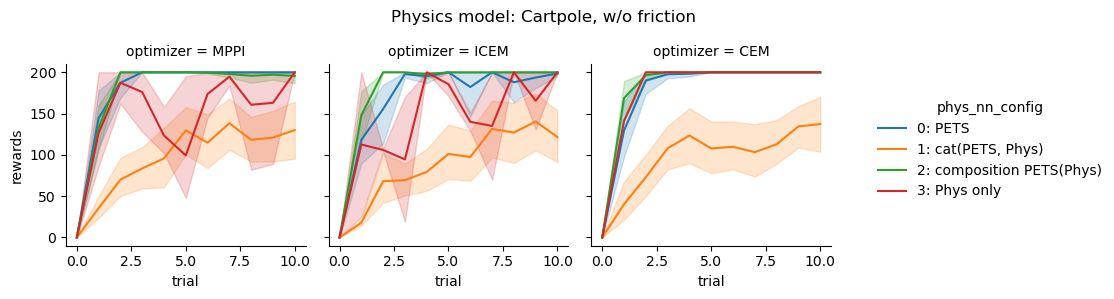

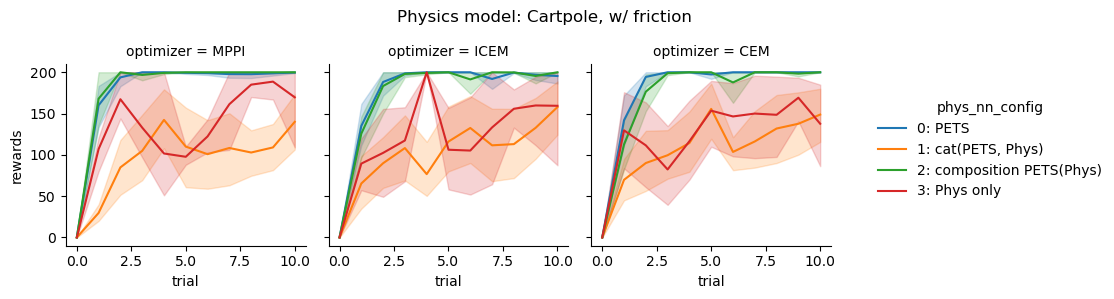

In [71]:
for fr in ['w/o friction', 'w/ friction']:
    if fr == 'w/o friction':
        results_i = result_s[result_s['env.track_friction'] == 0]

    else:
        results_i = result_s[result_s['env.track_friction'] != 0]

    result_i = results_i[results_i['physics_model'] =='cartpole']

    g = sns.FacetGrid(result_i, col='optimizer',
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards")
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle('Physics model: Cartpole, environment: cartpole {}'.format(fr))

# Long rollout test w/ wo synthetic pretrain

In [86]:
data_dirs = ['2023-05-10-long-rollout']
result_m, result_s = data_to_df(data_dirs,                 print_overrides=True, 
)
phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['pretrain_trial_length', 'seed']:
    result_s[c] = result_s[c].astype(float)



Time: 18-13-30
OVERRIDES: 

{'num_trials': '5',
 'optimizer': 'ICEM',
 'phys_nn_config': '0',
 'physics_model': 'sindy',
 'pretrain_trial_length': '10,50,100',
 'seed': '1',
 'synthetic_train': 'True',
 'trial_length': '2000'}
Time: 16-20-18
OVERRIDES: 

{'num_trials': '5',
 'optimizer': 'ICEM',
 'phys_nn_config': '2',
 'physics_model': 'sindy',
 'pretrain_trial_length': '10,50,100',
 'seed': '1',
 'synthetic_train': 'True',
 'trial_length': '2000'}
Time: 15-28-18
OVERRIDES: 

{'num_trials': '5',
 'optimizer': 'ICEM',
 'phys_nn_config': '0',
 'physics_model': 'sindy',
 'pretrain_trial_length': '10,50,100',
 'seed': '1',
 'synthetic_train': 'False',
 'trial_length': '2000'}


FileNotFoundError: [Errno 2] No such file or directory: '/home/gawelk/PhD/REAI/mbrl-lib-SINDy/REAI/multirun/2023-05-10-long-rollout/18-35-25/multirun.yaml'

In [87]:
for col in list(result_s.columns)[:-2]:
    print('{}: \t {}'.format(col ,result_s[col].unique()))

pretrain_trial_length: 	 [ 20.  10.  50. 100.]
optimizer: 	 ['MPPI' 'ICEM' 'CEM']
seed: 	 [3. 1. 2.]
phys_nn_config: 	 ['1: cat(PETS, Phys)' '3: Phys only' '0: PETS' '2: composition PETS(Phys)']
physics_model: 	 ['cartpole' 'sindy']
env.track_friction: 	 [0.05 0.  ]
env.joint_friction: 	 [0.1 0. ]


In [74]:
result_s[result_s['trial'] ==0]

,pretrain_trial_length,optimizer,seed,phys_nn_config,physics_model,trial_length,num_trials,synthetic_train,rewards,trial
0,10.0,ICEM,1.0,0: PETS,sindy,2000,5,True,0.0,0
6,100.0,ICEM,1.0,0: PETS,sindy,2000,5,True,0.0,0
12,50.0,ICEM,1.0,0: PETS,sindy,2000,5,True,0.0,0
18,10.0,ICEM,1.0,2: composition PETS(Phys),sindy,2000,5,True,0.0,0
24,100.0,ICEM,1.0,2: composition PETS(Phys),sindy,2000,5,True,0.0,0
30,50.0,ICEM,1.0,2: composition PETS(Phys),sindy,2000,5,True,0.0,0
36,10.0,ICEM,1.0,0: PETS,sindy,2000,5,False,0.0,0
42,100.0,ICEM,1.0,0: PETS,sindy,2000,5,False,0.0,0
48,50.0,ICEM,1.0,0: PETS,sindy,2000,5,False,0.0,0
54,10.0,ICEM,1.0,2: composition PETS(Phys),sindy,2000,5,True,0.0,0


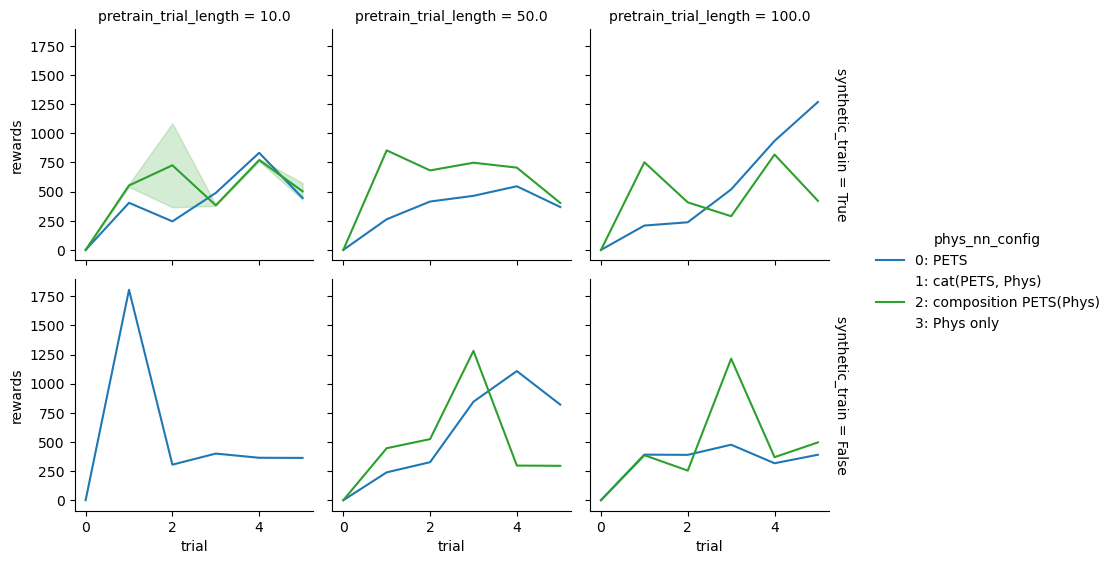

In [75]:
g = sns.FacetGrid(result_s, row="synthetic_train", col="pretrain_trial_length",
                hue = 'phys_nn_config',
                hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                margin_titles=True)

g.map(sns.lineplot, "trial", "rewards")
g.add_legend()
# add title
g.fig.subplots_adjust(top=0.9)
